In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay
)

In [5]:
pip install xlrd==2.0.1

In [5]:
# Load dataset
df = pd.read_excel("default of credit card clients.xls", header=1)

# Rename target column
df = df.rename(columns={"default payment next month": "default"})

print(df.shape)
print(df.head())

(30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0         0         0         0

In [11]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


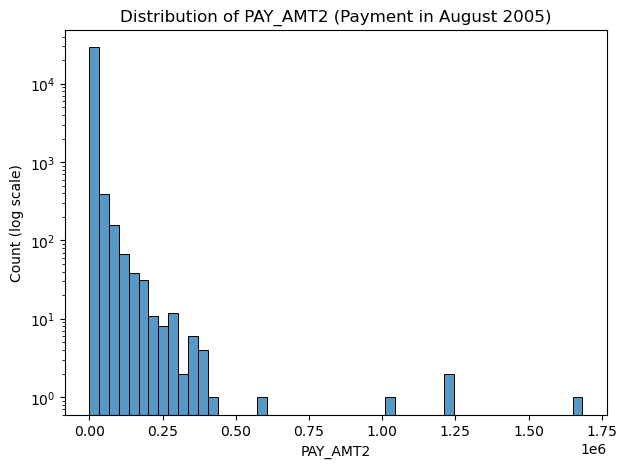

In [13]:
# Column PAY_AMT2 needs more inestigation
plt.figure(figsize=(7,5))
sns.histplot(df["PAY_AMT2"], bins=50, kde=False)
plt.yscale("log")   # log scale to handle extreme skew
plt.title("Distribution of PAY_AMT2 (Payment in August 2005)")
plt.xlabel("PAY_AMT2")
plt.ylabel("Count (log scale)")
plt.show()

#### Most clients paid small amounts or nothing at all (large spike near 0).
#### A small fraction of clients made very large payments (outliers in millions).
#### The distribution is highly skewed, which explains why scaling helps models.
#### Scailing is needed for this dataset

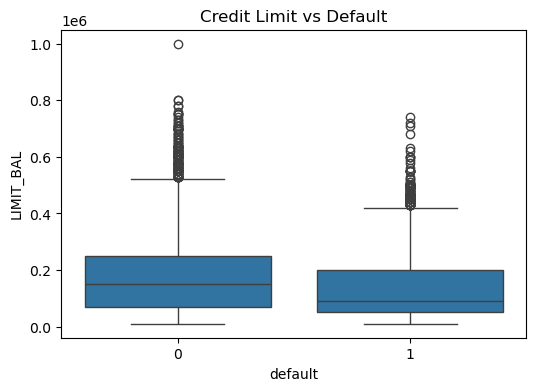

In [19]:
#Visualization 1: Default vs. Credit Limit
plt.figure(figsize=(6,4))
sns.boxplot(x="default", y="LIMIT_BAL", data=df)
plt.title("Credit Limit vs Default")
plt.show()


#### Defaulting customers often have lower credit limits, 
#### but some high-limit clients also default, showing risk is not only about income.

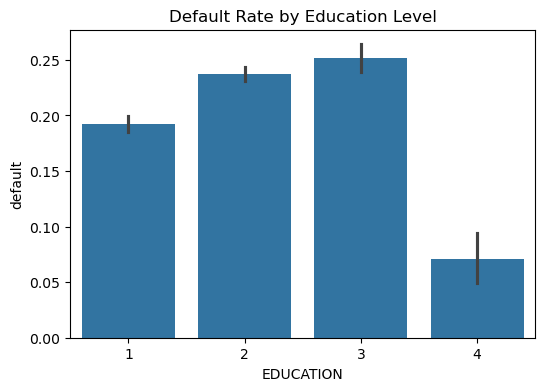

In [21]:
#Visualization 2: Default rate by Education
plt.figure(figsize=(6,4))
sns.barplot(x="EDUCATION", y="default", data=df, estimator=np.mean)
plt.title("Default Rate by Education Level")
plt.show()

#### Default rates differ by education level (e.g., higher among less-educated clients).
#### This suggests socio-economic factors may play a role.

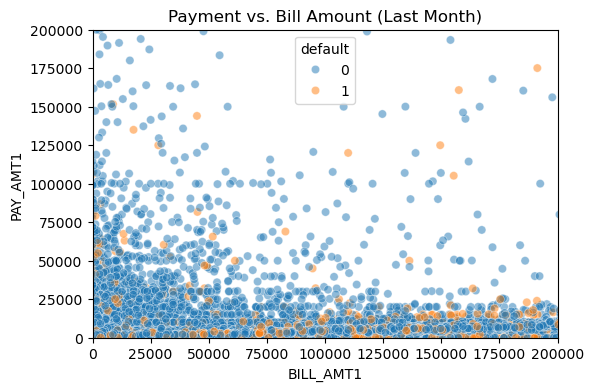

In [23]:
#Visualization 3: Bill Amount vs. Payment Amount (scatter)
plt.figure(figsize=(6,4))
sns.scatterplot(x="BILL_AMT1", y="PAY_AMT1", hue="default", data=df, alpha=0.5)
plt.title("Payment vs. Bill Amount (Last Month)")
plt.xlim(0, 200000)  # limit for better visibility
plt.ylim(0, 200000)
plt.show()

#### Many defaulters cluster near low payments despite high bills,
#### confirming non-payment patterns in high-debt clients.

In [25]:
from sklearn.preprocessing import StandardScaler

# Drop ID column if present
if "ID" in df.columns:
    df = df.drop(columns=["ID"])
# Fix categorical values (group rare/invalid values into "others")
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})
df["MARRIAGE"] = df["MARRIAGE"].replace({0: 3})

# Add simple engineered features
df["LIMIT_UTILIZATION"] = df["BILL_AMT1"] / (df["LIMIT_BAL"].replace(0, 1))   # avoid divide by 0
df["PAYMENT_RATIO"] = df["PAY_AMT1"] / (df["BILL_AMT1"].replace(0, 1))        # avoid divide by 0

# Features and target
X = df.drop(columns=["default"])
y = df["default"]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale all features (for simplicity, apply to all models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
# Logistic Regression
log_params = {"C": [0.01, 0.1, 1, 10]}
log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced"),
    param_grid=log_params, cv=3, scoring="f1"
)
log_grid.fit(X_train_scaled, y_train)

# Decision Tree
dt_params = {"max_depth": [3, 5, 7], "min_samples_split": [2, 5, 10]}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(class_weight="balanced", random_state=42),
    param_grid=dt_params, cv=3, scoring="f1"
)
dt_grid.fit(X_train_scaled, y_train)

# Gradient Boosting
gb_params = {"n_estimators": [50, 100], "learning_rate": [0.05, 0.1], "max_depth": [3, 5]}
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid=gb_params, cv=3, scoring="f1"
)
gb_grid.fit(X_train_scaled, y_train)

# Best models
log_best = log_grid.best_estimator_
dt_best = dt_grid.best_estimator_
gb_best = gb_grid.best_estimator_

print("Best Logistic Regression params:", log_grid.best_params_)
print("Best Decision Tree params:", dt_grid.best_params_)
print("Best Gradient Boosting params:", gb_grid.best_params_)

Best Logistic Regression params: {'C': 10}
Best Decision Tree params: {'max_depth': 3, 'min_samples_split': 2}
Best Gradient Boosting params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


##### Since the cost of missing a defaulter is much higher than wrongly flagging a good customer, Recall and F1-score are prioritized over Accuracy.
##### For this dataset and business case we use the following as our model evaluation score:
##### Primary metric: Recall (catch more defaulters).
##### Secondary metric: F1-score (balances recall & precision).
##### Tertiary metric: ROC-AUC (overall ranking ability).


Logistic Regression Results:
Accuracy: 0.689
Precision: 0.375
Recall: 0.61
F1: 0.465
ROC AUC: 0.711

Confusion Matrix:
 [[3325 1348]
 [ 517  810]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78      4673
           1       0.38      0.61      0.46      1327

    accuracy                           0.69      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.69      0.71      6000



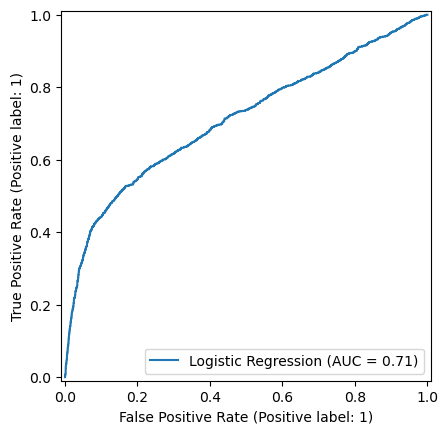


Decision Tree Results:
Accuracy: 0.75
Precision: 0.45
Recall: 0.58
F1: 0.507
ROC AUC: 0.737

Confusion Matrix:
 [[3734  939]
 [ 558  769]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      4673
           1       0.45      0.58      0.51      1327

    accuracy                           0.75      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.75      0.76      6000



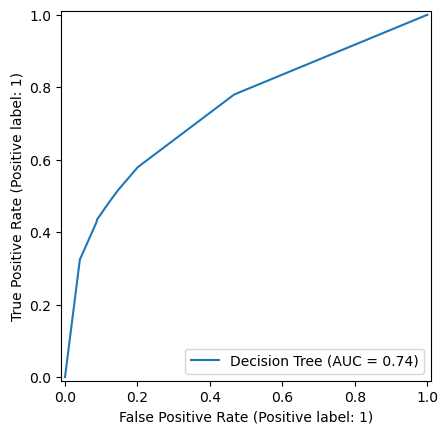


Gradient Boosting Results:
Accuracy: 0.819
Precision: 0.667
Recall: 0.364
F1: 0.471
ROC AUC: 0.781

Confusion Matrix:
 [[4432  241]
 [ 844  483]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.67      0.36      0.47      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



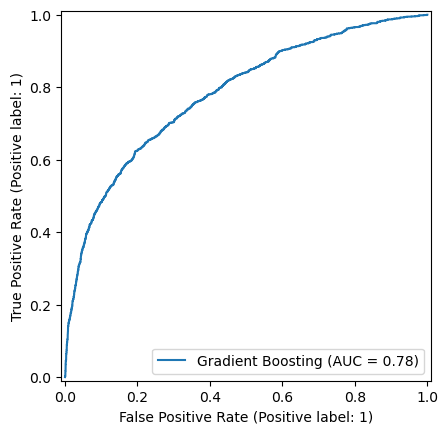

In [33]:
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test_scaled)
    probs = model.predict_proba(X_test_scaled)[:,1]

    print(f"\n{name} Results:")
    print("Accuracy:", round(accuracy_score(y_test, preds), 3))
    print("Precision:", round(precision_score(y_test, preds), 3))
    print("Recall:", round(recall_score(y_test, preds), 3))
    print("F1:", round(f1_score(y_test, preds), 3))
    print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, preds))
    print("\nClassification Report:\n", classification_report(y_test, preds))

    RocCurveDisplay.from_predictions(y_test, probs, name=name)
    plt.show()

# Evaluate all
evaluate_model("Logistic Regression", log_best, X_test, y_test)
evaluate_model("Decision Tree", dt_best, X_test, y_test)
evaluate_model("Gradient Boosting", gb_best, X_test, y_test)


#### Model Performance
##### Decision Tree
##### Accuracy: 0.75.
##### Recall (defaulters): 0.58 (slightly worse than logistic).
##### F1-score (defaulters): 0.51 (better than logistic).
##### Insight: A decent balance. It improves F1 and overall accuracy, but still misses ~42% of defaulters.

#### Since none of our model have given us a good score, we will retry data engineering and re-evaluate our model.

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# ----------------------------
# 1. Drop ID column if exists
# ----------------------------
if "ID" in df.columns:
    df = df.drop(columns=["ID"])

# ----------------------------
# 2. Clean categorical features
# ----------------------------
df["EDUCATION"] = df["EDUCATION"].replace({0: 4, 5: 4, 6: 4})
df["MARRIAGE"] = df["MARRIAGE"].replace({0: 3})

# ----------------------------
# 3. New engineered features
# ----------------------------

# Avg bill over 6 months
df["AVG_BILL_AMT"] = df[[f"BILL_AMT{i}" for i in range(1, 7)]].mean(axis=1)

# Avg payment over 6 months
df["AVG_PAY_AMT"] = df[[f"PAY_AMT{i}" for i in range(1, 7)]].mean(axis=1)

# Payment to bill ratio (most recent month)
df["PAYMENT_RATIO"] = df["PAY_AMT1"] / (df["BILL_AMT1"].replace(0, 1))

# Payment consistency (std dev of last 6 payments)
df["PAYMENT_STD"] = df[[f"PAY_AMT{i}" for i in range(1, 7)]].std(axis=1)

# Utilization: how much of limit is used (most recent bill)
df["UTILIZATION"] = df["BILL_AMT1"] / (df["LIMIT_BAL"].replace(0, 1))

# ----------------------------
# 4. Define X and y
# ----------------------------
X = df.drop(columns=["default"])
y = df["default"]

# ----------------------------
# 5. Train-test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 6. Balance dataset with SMOTE
# ----------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# ----------------------------
# 7. Scale data
# ----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())
print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)

Before SMOTE: {0: 18691, 1: 5309}
After SMOTE: {0: 18691, 1: 18691}
X_train shape: (37382, 29)
X_test shape: (6000, 29)


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# ----------------------------
# 1. Logistic Regression
# ----------------------------
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")
param_log = {
    "C": [0.01, 0.1, 1, 10]
}

grid_log = GridSearchCV(log_reg, param_log, cv=3, scoring="f1", n_jobs=-1)
grid_log.fit(X_train_scaled, y_train_res)

log_best = grid_log.best_estimator_
y_pred_log = log_best.predict(X_test_scaled)

print("Logistic Regression Best Params:", grid_log.best_params_)
print("ROC AUC:", roc_auc_score(y_test, log_best.predict_proba(X_test_scaled)[:,1]))
print(classification_report(y_test, y_pred_log))

# ----------------------------
# 2. Decision Tree
# ----------------------------
dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)
param_dt = {
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [10, 20, 50]
}

grid_dt = GridSearchCV(dt, param_dt, cv=3, scoring="f1", n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train_res)

dt_best = grid_dt.best_estimator_
y_pred_dt = dt_best.predict(X_test_scaled)

print("\nDecision Tree Best Params:", grid_dt.best_params_)
print("ROC AUC:", roc_auc_score(y_test, dt_best.predict_proba(X_test_scaled)[:,1]))
print(classification_report(y_test, y_pred_dt))

# ----------------------------
# 3. Gradient Boosting
# ----------------------------
gb = GradientBoostingClassifier(random_state=42)
param_gb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5]
}

grid_gb = GridSearchCV(gb, param_gb, cv=3, scoring="f1", n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train_res)

gb_best = grid_gb.best_estimator_
y_pred_gb = gb_best.predict(X_test_scaled)

print("\nGradient Boosting Best Params:", grid_gb.best_params_)
print("ROC AUC:", roc_auc_score(y_test, gb_best.predict_proba(X_test_scaled)[:,1]))
print(classification_report(y_test, y_pred_gb))

Logistic Regression Best Params: {'C': 10}
ROC AUC: 0.6980144236374651
              precision    recall  f1-score   support

           0       0.86      0.72      0.79      4673
           1       0.38      0.59      0.46      1327

    accuracy                           0.69      6000
   macro avg       0.62      0.65      0.62      6000
weighted avg       0.75      0.69      0.71      6000


Decision Tree Best Params: {'max_depth': 10, 'min_samples_split': 10}
ROC AUC: 0.7000276242603898
              precision    recall  f1-score   support

           0       0.85      0.80      0.83      4673
           1       0.42      0.51      0.46      1327

    accuracy                           0.74      6000
   macro avg       0.64      0.66      0.64      6000
weighted avg       0.76      0.74      0.75      6000


Gradient Boosting Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
ROC AUC: 0.7428103145408269
              precision    recall  f1-score   support

 

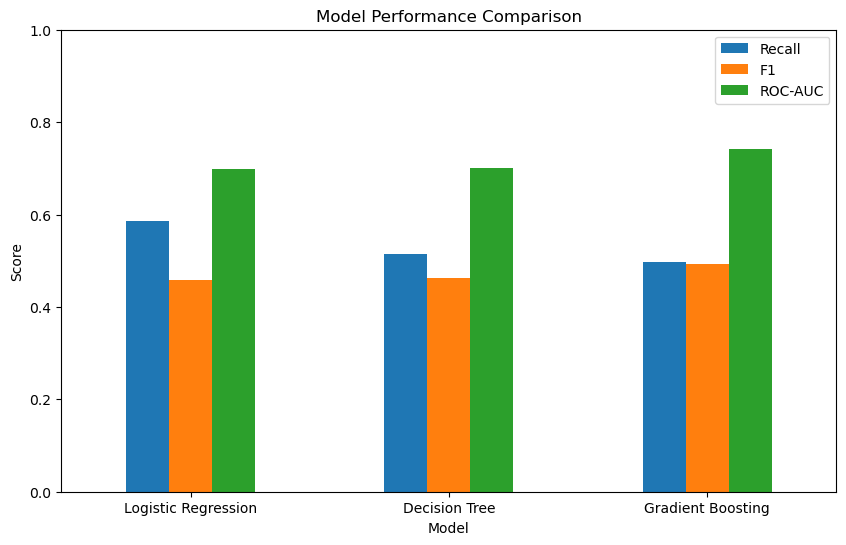

In [41]:
# Comparison Chart
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Collect metrics for each model
models = {
    "Logistic Regression": (y_test, y_pred_log, log_best.predict_proba(X_test_scaled)[:,1]),
    "Decision Tree": (y_test, y_pred_dt, dt_best.predict_proba(X_test_scaled)[:,1]),
    "Gradient Boosting": (y_test, y_pred_gb, gb_best.predict_proba(X_test_scaled)[:,1])
}

scores = {"Model": [], "Recall": [], "F1": [], "ROC-AUC": []}

for name, (y_true, y_pred, y_proba) in models.items():
    scores["Model"].append(name)
    scores["Recall"].append(recall_score(y_true, y_pred))
    scores["F1"].append(f1_score(y_true, y_pred))
    scores["ROC-AUC"].append(roc_auc_score(y_true, y_proba))

# Convert to DataFrame for plotting
scores_df = pd.DataFrame(scores)

# Plot
scores_df.set_index("Model")[["Recall","F1","ROC-AUC"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

##### We tested three models with hyperparameter tuning.
###### Logistic Regression gave better Recall (useful if business wants to catch more defaulters) but lower Precision.
###### Decision Tree was more balanced but not strong overall.
###### Gradient Boosting achieved the highest ROC AUC (0.74) and the best overall trade-off between Precision, Recall, and Accuracy.
###### For production, Gradient Boosting is recommended, but Logistic Regression can be considered if the business prioritizes Recall over Precision.